In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pyspark.sql.functions import mean, col
from random import random, randint
from urllib.request import urlretrieve

from mlflow import mlflow,log_metric, log_param, log_artifacts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

mlflow.set_tracking_uri('http://mlflow:5000')

%reload_ext autoreload
%autoreload 2

In [2]:
#mlflow.end_run()
mlflow.set_experiment('Default')

In [3]:
with mlflow.start_run() as run:
    print("Running mlflow_tracking.py")

    log_param("param1", randint(0, 100))

    log_metric("foo", random())
    log_metric("foo", random() + 1)
    log_metric("foo", random() + 2)

    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    with open("outputs/test.txt", "w") as f:
        f.write("hello world!")

    log_artifacts("outputs")

Running mlflow_tracking.py


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.\
        builder.\
        appName("mlflow-tracking").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "2048m").\
        config("spark.jars.packages", "io.delta:delta-core_2.12:0.7.0"). \
        config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension"). \
        config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog"). \
        getOrCreate()

from delta.tables import *

In [5]:
%run ./includes/utilities.ipynb

In [6]:
process_file(
  "health_profile_data.snappy.parquet",
  silverDailyPath,
  "health_profile_data"
)
process_file(
  "user_profile_data.snappy.parquet",
  dimUserPath,
  "user_profile_data"
)

Retrieve health_profile_data.snappy.parquet.
Load health_profile_data.snappy.parquet to /home/jovyan/work/dsc402/lpalum/mlmodels/profile/daily/
Register health_profile_data using path: /home/jovyan/work/dsc402/lpalum/mlmodels/profile/daily/
Retrieve user_profile_data.snappy.parquet.
Load user_profile_data.snappy.parquet to /home/jovyan/work/dsc402/lpalum/mlmodels/profile/users/
Register user_profile_data using path: /home/jovyan/work/dsc402/lpalum/mlmodels/profile/users/


## Read the user and health profile data

In [7]:
user_profile_df = spark.read.table("user_profile_data")
health_profile_df = spark.read.table("health_profile_data")

## Generate a sample of the users

In [8]:
user_profile_sample_df = user_profile_df.sample(0.1)

user_profile_sample_df.groupby("lifestyle").count().show()

+--------------+-----+
|     lifestyle|count|
+--------------+-----+
|     sedentary|   95|
|weight trainer|   92|
|cardio trainer|  113|
+--------------+-----+



In [9]:
# TODO Join the user profile sample with the health data
health_profile_sample_df = (
  user_profile_sample_df
  .join(health_profile_df, "_id")
)

assert 365*user_profile_sample_df.count() == health_profile_sample_df.count()

In [10]:
health_profile_sample_df.show(n=2)

+--------------------+----------+---------+--------------+------+-------+----------------+-------------------+-----------------+------------------+------------------+-----------------+------------------+
|                 _id|first_name|last_name|     lifestyle|female|country|      occupation|                dte|resting_heartrate|  active_heartrate|               BMI|          VO2_max|   workout_minutes|
+--------------------+----------+---------+--------------+------+-------+----------------+-------------------+-----------------+------------------+------------------+-----------------+------------------+
|d265d7f8-e48a-11e...| Christine|    Hobbs|weight trainer|  true|    BRA|Transport-moving|2019-01-01 00:00:00|54.53843356892305|118.69647444882607|25.130326716497667|33.07730725848996| 28.72268502003041|
|d265d7f8-e48a-11e...| Christine|    Hobbs|weight trainer|  true|    BRA|Transport-moving|2019-01-02 00:00:00|67.16297999977505| 129.2220395597414| 24.65027384544658|33.18382723254913|

In [11]:
from pyspark.sql.functions import mean, col

health_tracker_sample_agg_df = (
    health_profile_sample_df.groupBy("_id")
    .agg(
        mean("BMI").alias("mean_BMI"),
        mean("active_heartrate").alias("mean_active_heartrate"),
        mean("resting_heartrate").alias("mean_resting_heartrate"),
        mean("VO2_max").alias("mean_VO2_max"),
        mean("workout_minutes").alias("mean_workout_minutes")
    )
)

In [12]:
health_tracker_sample_agg_df.show(n=2)

+--------------------+------------------+---------------------+----------------------+------------------+--------------------+
|                 _id|          mean_BMI|mean_active_heartrate|mean_resting_heartrate|      mean_VO2_max|mean_workout_minutes|
+--------------------+------------------+---------------------+----------------------+------------------+--------------------+
|ed5b77de-e48a-11e...|20.333683745375815|   100.32251622502783|     51.03912772943997|39.853055182561214|  26.642748895487937|
|fde6ba78-e48a-11e...| 24.38730195863408|   141.91861189134633|      73.0347968797731| 25.68860480668845|     8.2329345132989|
+--------------------+------------------+---------------------+----------------------+------------------+--------------------+
only showing top 2 rows



In [13]:
health_tracker_augmented_df = (
  health_tracker_sample_agg_df
  .join(user_profile_df, "_id")
)

In [14]:
health_tracker_augmented_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- mean_BMI: double (nullable = true)
 |-- mean_active_heartrate: double (nullable = true)
 |-- mean_resting_heartrate: double (nullable = true)
 |-- mean_VO2_max: double (nullable = true)
 |-- mean_workout_minutes: double (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- lifestyle: string (nullable = true)
 |-- female: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- occupation: string (nullable = true)



In [15]:
from pyspark.sql.types import _parse_datatype_string

augmented_schema = """
  mean_BMI double,
  mean_active_heartrate double,
  mean_resting_heartrate double,
  mean_VO2_max double,
  mean_workout_minutes double,
  female boolean,
  country string,
  occupation string,
  lifestyle string
"""

health_tracker_augmented_df = (health_tracker_augmented_df.select(["mean_BMI",
                                                                   "mean_active_heartrate",
                                                                   "mean_resting_heartrate",
                                                                   "mean_VO2_max",
                                                                   "mean_workout_minutes",
                                                                   "female",
                                                                   "country",
                                                                   "occupation",
                                                                   "lifestyle"
                                                                  ]))



assert health_tracker_augmented_df.schema == _parse_datatype_string(augmented_schema)

In [16]:
health_tracker_augmented_df.show()

+------------------+---------------------+----------------------+------------------+--------------------+------+-------+-----------------+--------------+
|          mean_BMI|mean_active_heartrate|mean_resting_heartrate|      mean_VO2_max|mean_workout_minutes|female|country|       occupation|     lifestyle|
+------------------+---------------------+----------------------+------------------+--------------------+------+-------+-----------------+--------------+
|20.333683745375815|   100.32251622502783|     51.03912772943997|39.853055182561214|  26.642748895487937|  true|    USA|Handlers-cleaners|cardio trainer|
| 24.38730195863408|   141.91861189134633|      73.0347968797731| 25.68860480668845|     8.2329345132989|  true|    ITA|  Priv-house-serv|     sedentary|
|19.515680262735753|   127.12082146097072|     56.19930431692095|38.490634308277215|   26.87109109636686|  true|    USA|     Armed-Forces|weight trainer|
|17.773428463424843|    98.17843293857379|     52.71869130113522|33.61878346

## Write the augmented data to the delta table

In [17]:
(
  health_tracker_augmented_df.write
  .format("delta")
  .mode("overwrite")
  .save(goldPath + "health_tracker_augmented")
)

## Read the augmented (gold) data from the delata lake

In [18]:
health_tracker_augmented_df = (
  spark.read
  .format("delta")
  .load(goldPath + "health_tracker_augmented")
  .toPandas()
)

In [19]:
lifestyles = health_tracker_augmented_df.lifestyle.unique()
lifestyles

array(['weight trainer', 'cardio trainer', 'sedentary'], dtype=object)

In [20]:
features = health_tracker_augmented_df.drop("lifestyle", axis=1)
target = health_tracker_augmented_df[["lifestyle"]].copy()

In [21]:
features.sample(10)

,mean_BMI,mean_active_heartrate,mean_resting_heartrate,mean_VO2_max,mean_workout_minutes,female,country,occupation
151,14.639939,112.449479,53.917895,34.035093,26.708980,True,JPN,Exec-managerial
39,21.730039,115.056025,58.132203,36.125527,26.295189,True,USA,Handlers-cleaners
17,28.572194,135.409082,72.199596,29.319957,8.218835,False,USA,Machine-op-inspct
156,23.576535,104.800208,56.004742,34.731868,25.058538,True,BRA,Exec-managerial
287,15.397273,98.218701,51.990553,38.478069,25.974845,False,ITA,Priv-house-serv
23,28.886973,123.798555,61.685819,29.231060,25.615557,False,USA,Armed-Forces
6,23.415076,125.445984,56.498759,36.079541,25.238971,True,USA,Tech-support
249,26.542593,119.106087,58.415693,33.319641,26.727024,False,USA,Tech-support
298,26.743363,126.370465,73.703144,24.661156,8.017643,True,USA,Farming-fishing
164,24.413202,125.749314,58.899928,33.388871,27.637441,False,BRA,Farming-fishing


In [22]:
features.dtypes

mean_BMI                  float64
mean_active_heartrate     float64
mean_resting_heartrate    float64
mean_VO2_max              float64
mean_workout_minutes      float64
female                       bool
country                    object
occupation                 object
dtype: object

In [23]:
features_numerical = features.select_dtypes(include=[float])
features_categorical = features.select_dtypes(exclude=[float])

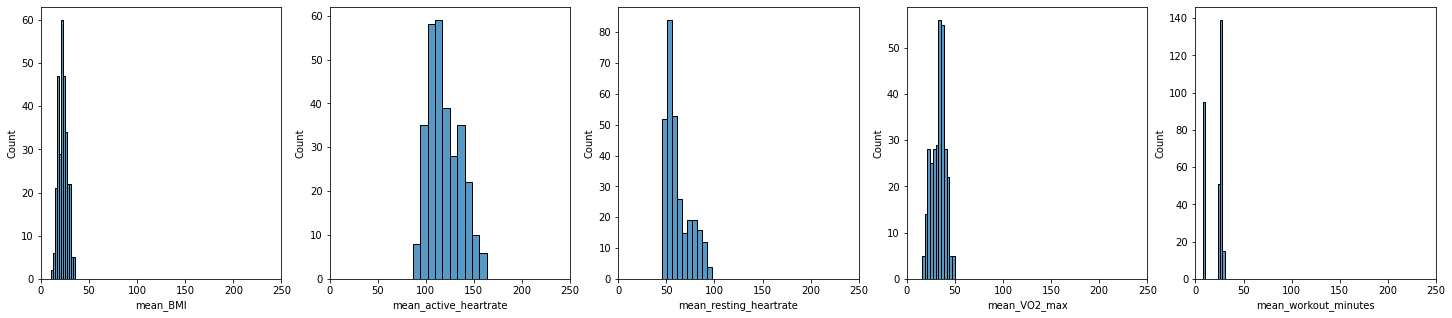

In [24]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  sns.histplot(features[feature], ax=ax[i])
  ax[i].set_xlim(0,250)

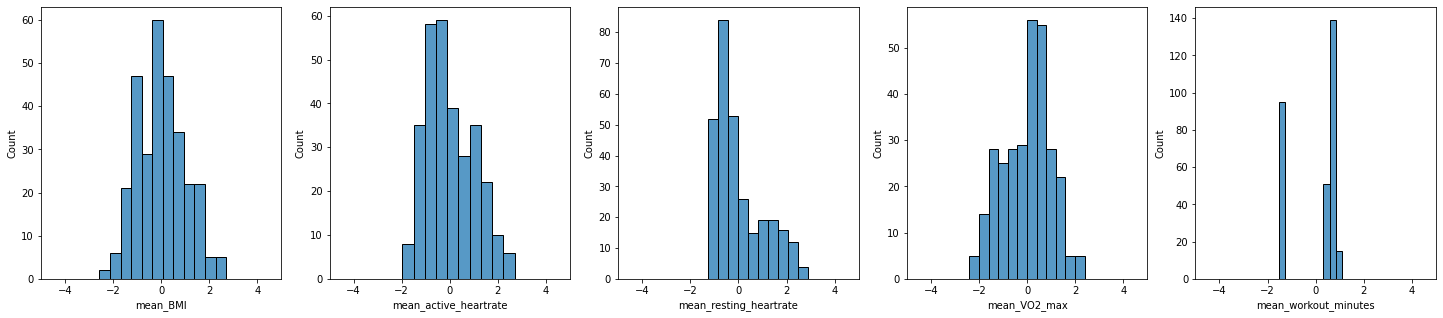

In [25]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  feature_series = features[feature]
  feature_scaled = (feature_series - feature_series.mean())/feature_series.std()
  sns.histplot(feature_scaled, ax=ax[i])
  ax[i].set_xlim(-5, 5)

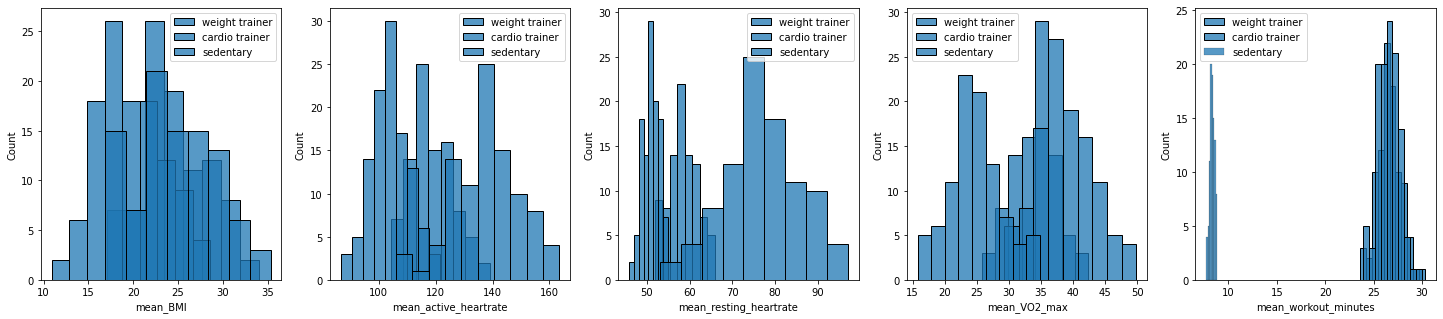

In [26]:
fig, ax = plt.subplots(1,5, figsize=(25,5))
for i, feature in enumerate(features_numerical):
  for lifestyle in lifestyles:
    subset = features[target["lifestyle"] == lifestyle]
    sns.histplot(subset[feature], ax=ax[i], label=lifestyle)
  ax[i].legend()

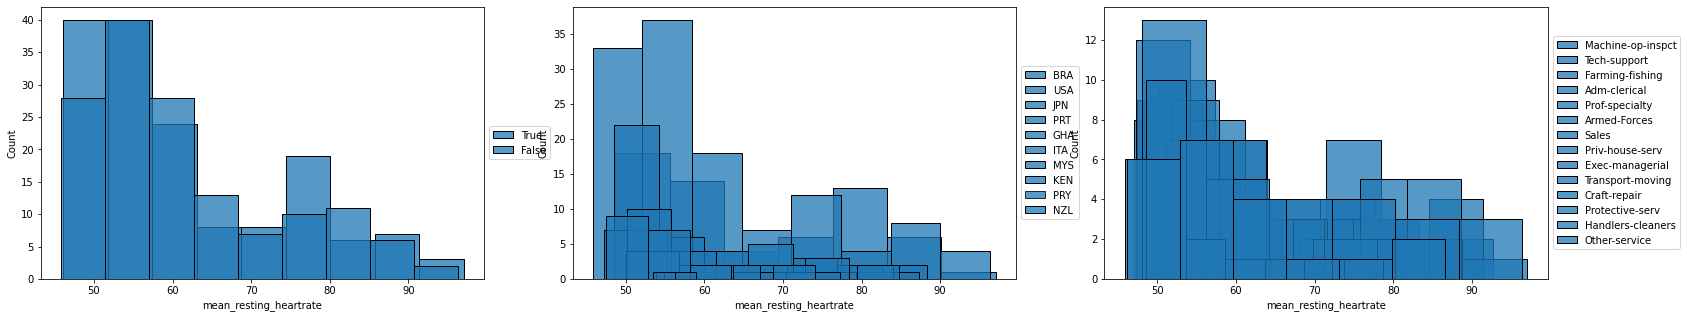

In [27]:
fig, ax = plt.subplots(1,3, figsize=(27,5))

for i, feature in enumerate(features_categorical):
  for value in features[feature].unique():
    subset = features[features[feature] == value]
    sns.histplot(subset["mean_resting_heartrate"], ax=ax[i], label=value)
  ax[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

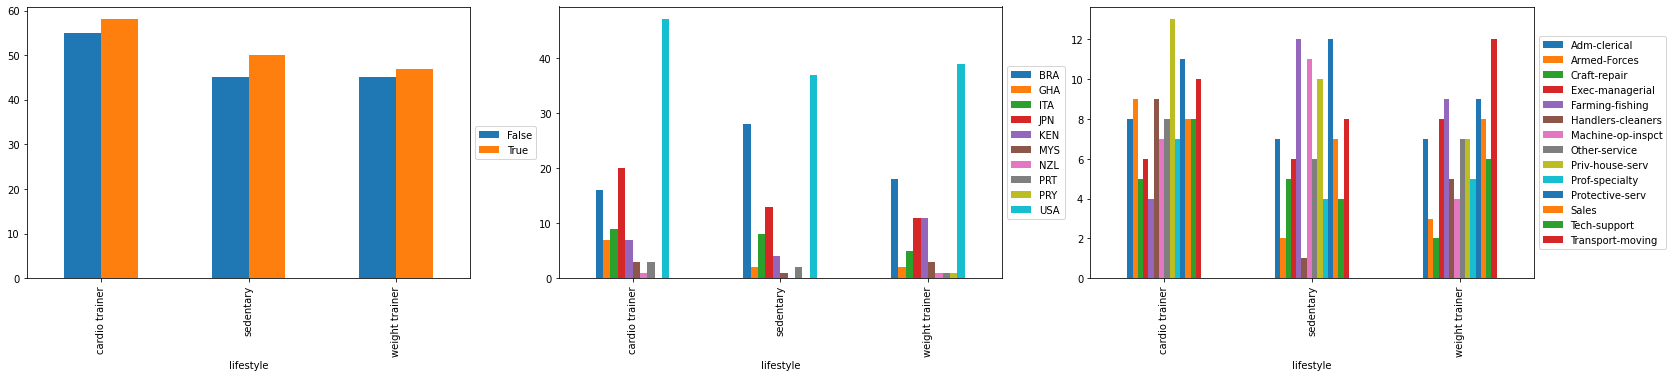

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(27,5))
(
  health_tracker_augmented_df
  .groupby("female")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[0]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
(
  health_tracker_augmented_df
  .groupby("country")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[1]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
(
  health_tracker_augmented_df
  .groupby("occupation")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[2]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

In [29]:
pd.get_dummies(features_categorical)

,female,country_BRA,country_GHA,country_ITA,country_JPN,country_KEN,country_MYS,country_NZL,country_PRT,country_PRY,...,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,True,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,False,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,True,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,False,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
297,False,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
298,True,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
ohe.fit_transform(features_categorical)

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

# Building a Linear Customer Classfication Model

In [31]:
from sklearn.preprocessing import LabelEncoder

features = health_tracker_augmented_df.drop("lifestyle", axis=1)
target = health_tracker_augmented_df["lifestyle"]
le = LabelEncoder()
target = le.fit_transform(target)

In [32]:
# Perform Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target)

In [33]:
# Split Data into Numerical and Categorical Sets
X_train_numerical = X_train.select_dtypes(exclude=["object"])
X_test_numerical = X_test.select_dtypes(exclude=["object"])
X_train_categorical = X_train.select_dtypes(include=["object"])
X_test_categorical = X_test.select_dtypes(include=["object"])

In [34]:
ss = StandardScaler()
ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')

# Create One-Hot Encoded Categorical DataFrames
X_train_ohe = pd.DataFrame(
  ohe.fit_transform(X_train_categorical),
  columns=ohe.get_feature_names(),
  index=X_train_numerical.index
)
X_test_ohe = pd.DataFrame(
  ohe.transform(X_test_categorical),
  columns=ohe.get_feature_names(),
  index=X_test_numerical.index
)

In [35]:
# Merge Numerical and One-Hot Encoded Categorical
X_train = X_train_numerical.merge(X_train_ohe, left_index=True, right_index=True)
X_test = X_test_numerical.merge(X_test_ohe, left_index=True, right_index=True)

In [36]:
# Standardize Data
X_train = pd.DataFrame(
  ss.fit_transform(X_train),
  index=X_train_ohe.index,
  columns=X_train.columns)
X_test = pd.DataFrame(
  ss.transform(X_test),
  index=X_test_ohe.index,
  columns=X_train.columns)

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
data = (X_train, X_test, y_train, y_test)

Grid-Searched Model Fitting
The following models were fit using a grid-searched, cross validation with the respective parameter dictionaries:

Ridge,
{'alpha' : logspace(-5,5,11)}
Lasso,
{'alpha' : logspace(-5,5,11)}
Elastic Net,
{'alpha' : logspace(-5,5,11), 'l1_ratio' : linspace(0,1,11)}

In [39]:
try:
    experiment_id = mlflow.create_experiment('heath-lifestyle-classification-modeling')
except:
    print("experiment already created")
    experiment_id = mlflow.get_experiment_by_name('heath-lifestyle-classification-modeling').experiment_id

experiment already created


In [40]:
print(experiment_id)

1


In [41]:
from dsas.experiment import mlflow_run, prepare_coefs, prepare_results

In [42]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['l2']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [43]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['l1'], "solver" : ['saga']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [44]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['elasticnet'],
  'l1_ratio' : np.linspace(0,1,11),
  "solver" : ['saga']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [45]:
experiments = prepare_results(experiment_id)
experiments.head()

,artifact_uri,metrics.test acc,metrics.train acc,params.penalty,params.l1_ratio,params.solver,params.model,params.C
0,s3://mlflow/1/a88627ae87834720be1481e5200160bc...,0.973333,0.982222,elasticnet,1.0,saga,LogisticRegression,1.0
1,s3://mlflow/1/613527519b8040738a9844c661ed3c2a...,0.973333,0.982222,l1,None,saga,LogisticRegression,1.0
2,s3://mlflow/1/46c1cf21002448399a3e721854d21203...,0.973333,0.991111,l2,None,None,LogisticRegression,10.0
3,s3://mlflow/1/51cb56d7623b4cd8b037205d9e416790...,0.972603,0.981567,elasticnet,1.0,saga,LogisticRegression,1.0
4,s3://mlflow/1/d3f341cdfc0940dfac1438d735f679b1...,0.972603,0.981567,l1,None,saga,LogisticRegression,1.0


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jovyan/work/dsas/experiment.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax = coefs.T.plot(figsize=(20,7))
<ipython-input-46-2376f7c1249a>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  prepare_coefs(experiments, le.classes_, X_train.columns)


(                                            mean_BMI  mean_active_heartrate  \
 C       l1_ratio penalty    lifestyle                                         
 1.0     1.0      elasticnet cardio trainer -1.640683              -2.401925   
                             sedentary       0.000000               0.000000   
                             weight trainer  0.000000               0.000000   
         NaN      l1         cardio trainer -1.640534              -2.402110   
                             sedentary       0.000000               0.000000   
                             weight trainer  0.000000               0.000000   
 10.0    NaN      l2         cardio trainer -1.616943              -2.535878   
                             sedentary       0.627121               1.468586   
                             weight trainer  0.989822               1.067292   
 1.0     1.0      elasticnet cardio trainer -1.576720              -2.354485   
                             sedentary  

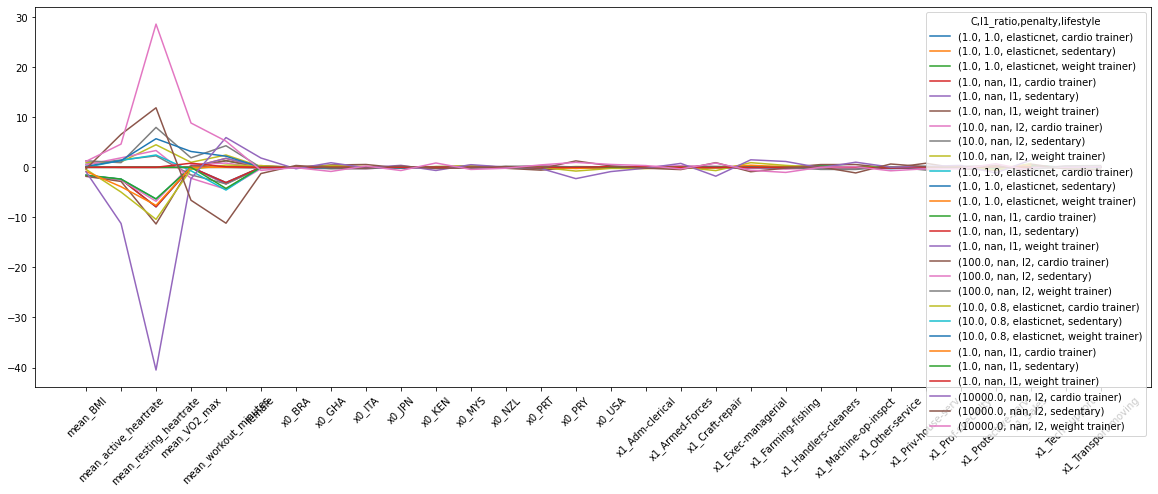

In [46]:
prepare_coefs(experiments, le.classes_, X_train.columns)

In [47]:
#spark.stop()